In [1]:
import pandas
import os
import numpy
directory = "./thauera-files/ThaueraPaper/"

In [2]:
from upsetplot import plot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

## Upset plot

In [3]:
def get_union(sets):
    union = set()
    for s in sets:
        union = union.union(s)
    return union

def get_presence(all_elems, sets):
    presence = list()
    for e in all_elems:
        tmp = [e in s for s in sets]
        presence.append(tmp)
    return presence

def get_upset_data(sets,set_names=[]):
    if not set_names:
        set_names = [str(i) for i in numpy.arange(len(sets))]
    all_elems = get_union(sets)
    presence = get_presence(all_elems,sets)
    df = pandas.DataFrame(presence, columns = set_names)

    presence = pandas.DataFrame(presence,columns = set_names)
    presence.index = all_elems
    return df,df.groupby(set_names).size(), presence

In [4]:
polymerList = pandas.read_csv(directory+"polymerList.txt",index_col=0,header=None).index.to_list()

## Aerobic

In [5]:
Data = pandas.read_csv(directory+"aerobicLethalRxns.csv",header=None)
Data.columns = ["rxn","orphan","subsystem","class"] + polymerList
Data = Data.set_index("rxn")

In [6]:
Data

,orphan,subsystem,class,eps1_c,eps2_c,eps3_c,eps4_c,eps5_c,eps6_c,PHB
rxn,,,,,,,,,,
A5PISO,1,Alternate Carbon Metabolism,Alternate Carbon Metabolism,1,1,1,1,1,1,1
ACFUCMSYN,1,Others,Others,1,1,1,0,0,1,0
ACGAMPM,0,Alternate Carbon Metabolism,Alternate Carbon Metabolism,1,1,1,1,1,1,0
ACHBS,1,"Valine, Leucine, and Isoleucine Metabolism",Amino acid Metabolism,0,0,1,1,1,0,1
ACLS,1,"Valine, Leucine, and Isoleucine Metabolism",Amino acid Metabolism,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
UMPK,1,Nucleotide Salvage Pathway,Nucleotide Metabolism,1,1,1,1,1,1,1
UPP3MT,1,Cofactor and Prosthetic Group Biosynthesis,Cofactor and Prosthetic Group Biosynthesis,1,1,1,1,1,1,1
UPP3S,1,Cofactor and Prosthetic Group Biosynthesis,Cofactor and Prosthetic Group Biosynthesis,1,1,1,1,1,1,1


In [7]:
sets = []
for i in polymerList:
    sets.append(Data[Data[i]==1].index.to_list())

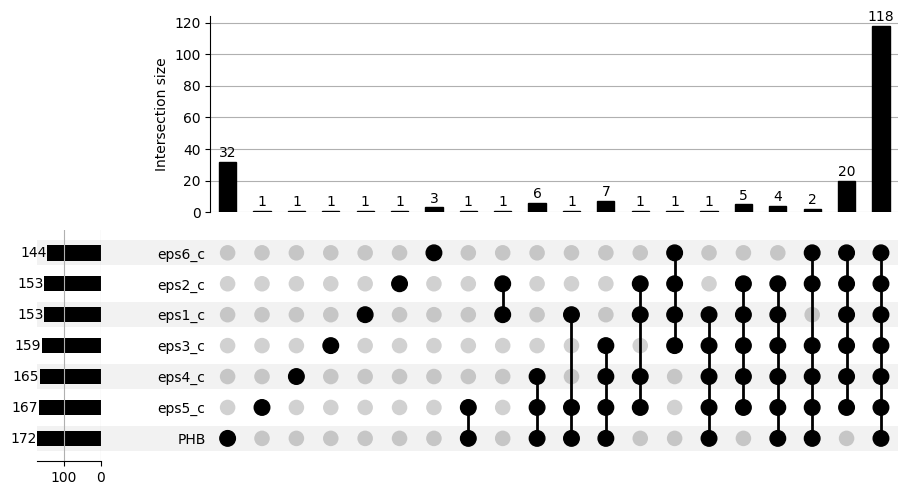

In [8]:
df,grouped,presence = get_upset_data(sets,set_names=polymerList)
UP=plot(grouped, orientation='horizontal', show_counts=True)
plt.savefig("./figures/reaction-aerobic-upset.svg",format="SVG")

In [9]:
import itertools
flags = list(itertools.product([False, True], repeat=len(polymerList)))
for idx,i in enumerate(polymerList):
    t = [None]*len(polymerList)
    t[idx] = True
    flags.append(tuple(t))

In [10]:
dct = {}
groups = {}
group = 1
for flag in flags:
    slice = Data[polymerList].copy()
    for idx,f in enumerate(flag):
        slice = slice[slice[polymerList[idx]] == f]
    if slice.empty : continue
    groups[group] = flag
    dct[group] = slice.index.to_list()
    group += 1

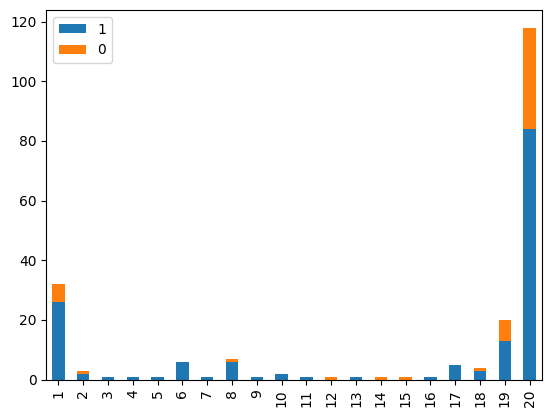

In [11]:
orphans = pandas.DataFrame()
for g,lst in dct.items():
    orphans[g] = Data.loc[lst]["orphan"].value_counts()
orphans = orphans.fillna(0.)
orphans.T.plot.bar(stacked=True)
plt.savefig("./figures/reaction-aerobic-stacked.svg",format="SVG")

<Axes: >

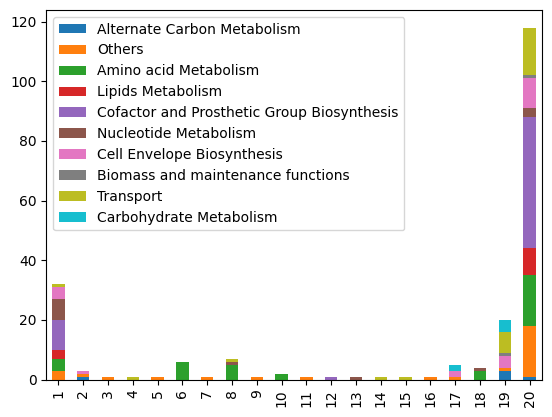

In [12]:
subsystems = pandas.DataFrame(columns=Data["class"].unique()).T
for g,lst in dct.items():
    subsystems[g] = Data.loc[lst]["class"].value_counts()
subsystems = subsystems
subsystems.T.plot.bar(stacked=True)

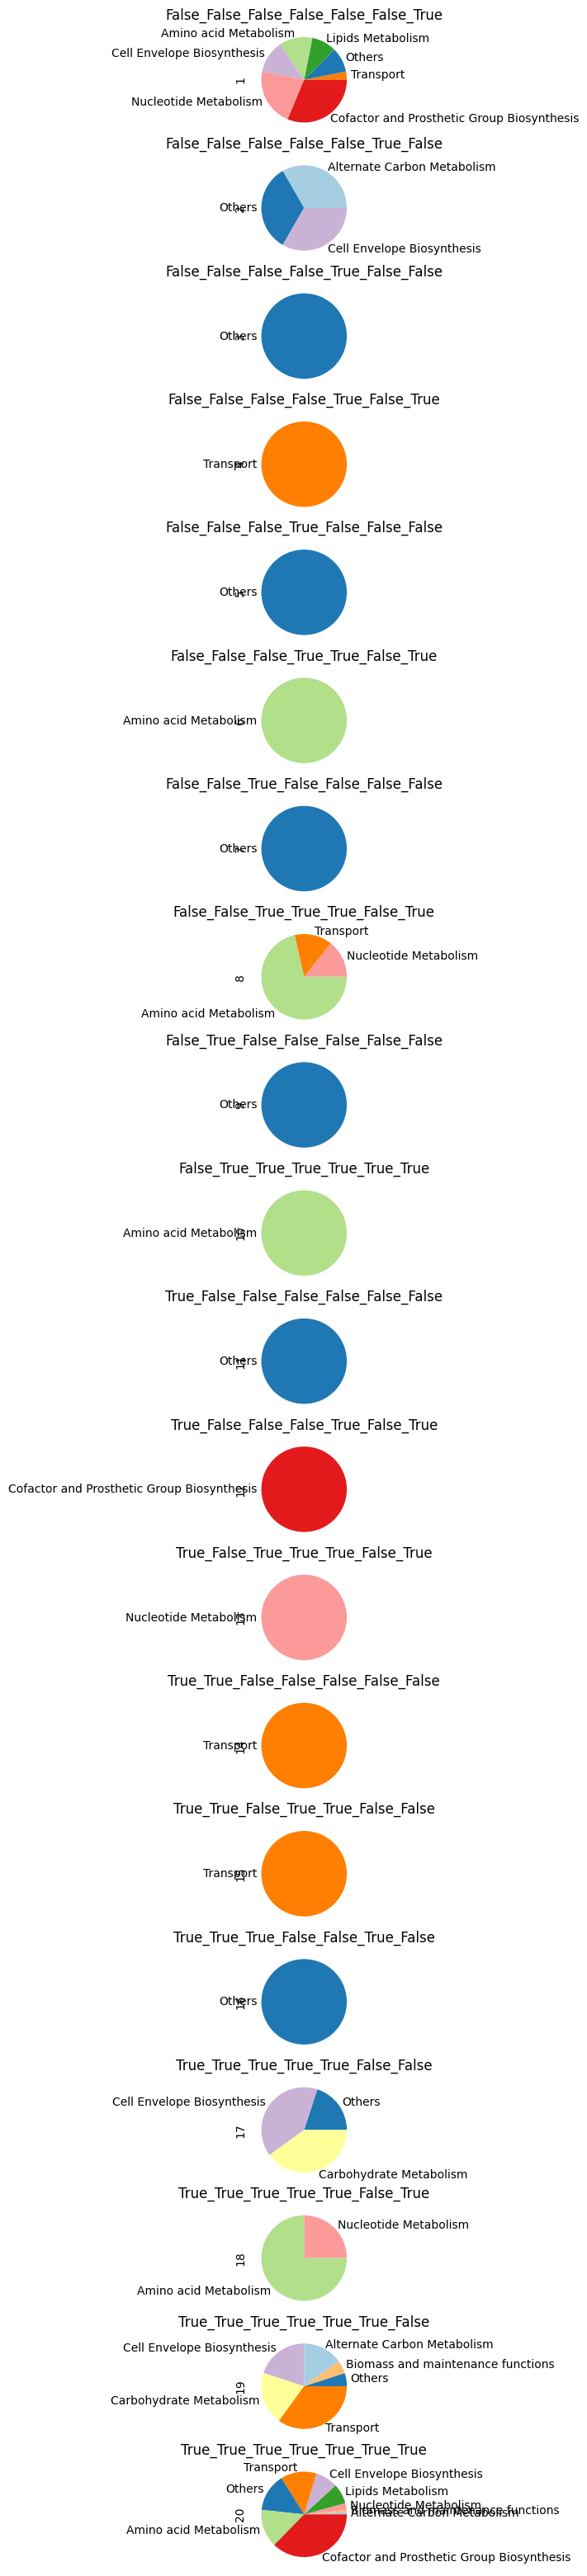

In [13]:
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
color_dct = {'Alternate Carbon Metabolism': '#a6cee3',
 'Others': '#1f78b4',
 'Amino acid Metabolism': '#b2df8a',
 'Lipids Metabolism': '#33a02c',
 'Nucleotide Metabolism': '#fb9a99',
 'Cofactor and Prosthetic Group Biosynthesis': '#e31a1c',
 'Biomass and maintenance functions': '#fdbf6f',
 'Transport': '#ff7f00',
 'Cell Envelope Biosynthesis': '#cab2d6',
 'Nitrogen Metabolism': '#6a3d9a',
 'Carbohydrate Metabolism': '#ffff99'}

fig,ax = plt.subplots(len(dct),1,figsize=(5,40))
for idx,(g,lst) in enumerate(dct.items()):
    name = "_".join([str(i) for i in groups[g]])
    tmp = subsystems[g].fillna(0.).sort_values()
    tmp.plot.pie(colors=[color_dct[i] for i in tmp.index],ax=ax[idx])
    ax[idx].set_title(name)
plt.savefig("./figures/reaction-aerobic-pies.svg",format="SVG")

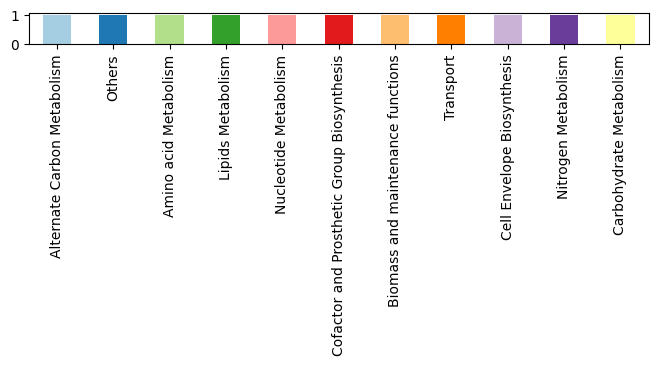

In [14]:
pandas.Series({k:1 for k in color_dct}).plot.bar(color=[color_dct[i] for i in color_dct],figsize=(8,0.4))
plt.savefig("./figures/reaction-aerobic-colorbar.svg",format="SVG")

## Anaerobic

In [15]:
Data = pandas.read_csv(directory+"anaerobicLethalRxns.csv",header=None)
Data.columns = ["rxn","orphan","subsystem","class"] + polymerList
Data = Data.set_index("rxn")

In [16]:
sets = []
for i in polymerList:
    sets.append(Data[Data[i]==1].index.to_list())

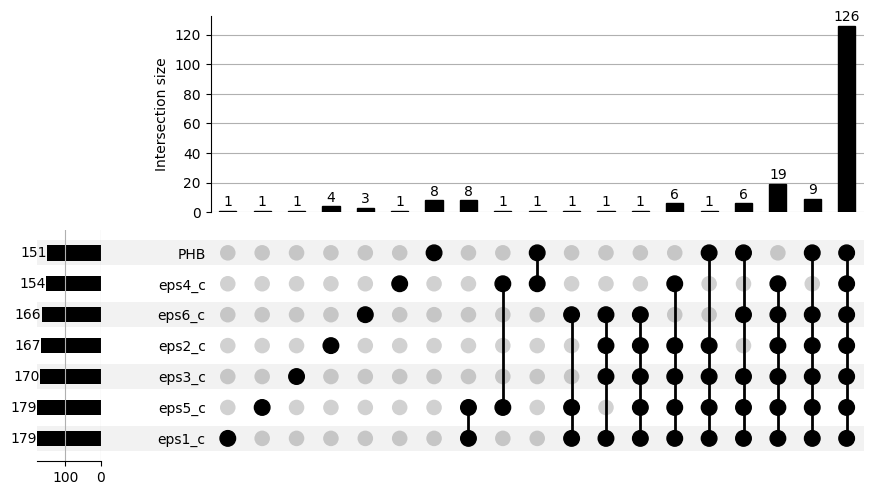

In [17]:
df,grouped,presence = get_upset_data(sets,set_names=polymerList)
UP=plot(grouped, orientation='horizontal', show_counts=True)
plt.savefig("./figures/reaction-anaerobic-upset.svg",format="SVG")

In [18]:
import itertools
flags = list(itertools.product([False, True], repeat=len(polymerList)))
for idx,i in enumerate(polymerList):
    t = [None]*len(polymerList)
    t[idx] = True
    flags.append(tuple(t))

In [19]:
dct = {}
groups = {}
group = 1
for flag in flags:
    slice = Data[polymerList].copy()
    for idx,f in enumerate(flag):
        slice = slice[slice[polymerList[idx]] == f]
    if slice.empty : continue
    groups[group] = flag
    dct[group] = slice.index.to_list()
    group += 1

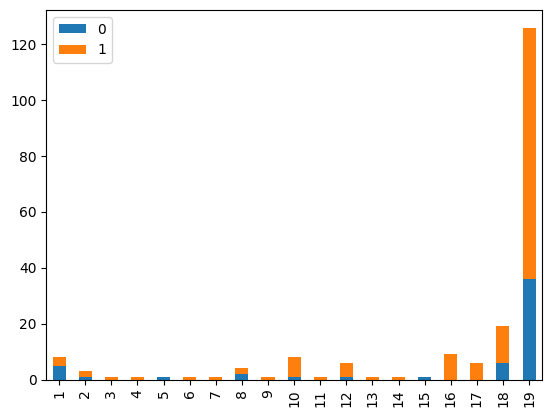

In [20]:
orphans = pandas.DataFrame()
for g,lst in dct.items():
    orphans[g] = Data.loc[lst]["orphan"].value_counts()
orphans = orphans.fillna(0.)
orphans.T.plot.bar(stacked=True)
plt.savefig("./figures/reaction-anaerobic-stacked.svg",format="SVG")

In [21]:
groups

{1: (False, False, False, False, False, False, True),
 2: (False, False, False, False, False, True, False),
 3: (False, False, False, False, True, False, False),
 4: (False, False, False, True, False, False, False),
 5: (False, False, False, True, False, False, True),
 6: (False, False, False, True, True, False, False),
 7: (False, False, True, False, False, False, False),
 8: (False, True, False, False, False, False, False),
 9: (True, False, False, False, False, False, False),
 10: (True, False, False, False, True, False, False),
 11: (True, False, False, False, True, True, False),
 12: (True, False, True, False, True, True, True),
 13: (True, True, True, False, False, True, False),
 14: (True, True, True, False, True, False, True),
 15: (True, True, True, False, True, True, False),
 16: (True, True, True, False, True, True, True),
 17: (True, True, True, True, True, False, False),
 18: (True, True, True, True, True, True, False),
 19: (True, True, True, True, True, True, True)}

In [22]:
orphans.sum()

1       8.0
2       3.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       4.0
9       1.0
10      8.0
11      1.0
12      6.0
13      1.0
14      1.0
15      1.0
16      9.0
17      6.0
18     19.0
19    126.0
dtype: float64

<Axes: >

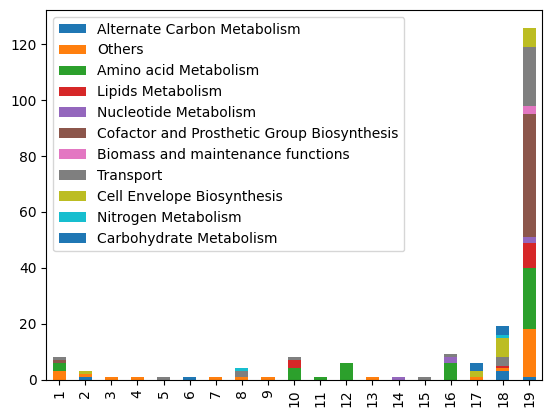

In [23]:
subsystems = pandas.DataFrame(columns=Data["class"].unique()).T
for g,lst in dct.items():
    subsystems[g] = Data.loc[lst]["class"].value_counts()
subsystems = subsystems
subsystems.T.plot.bar(stacked=True)

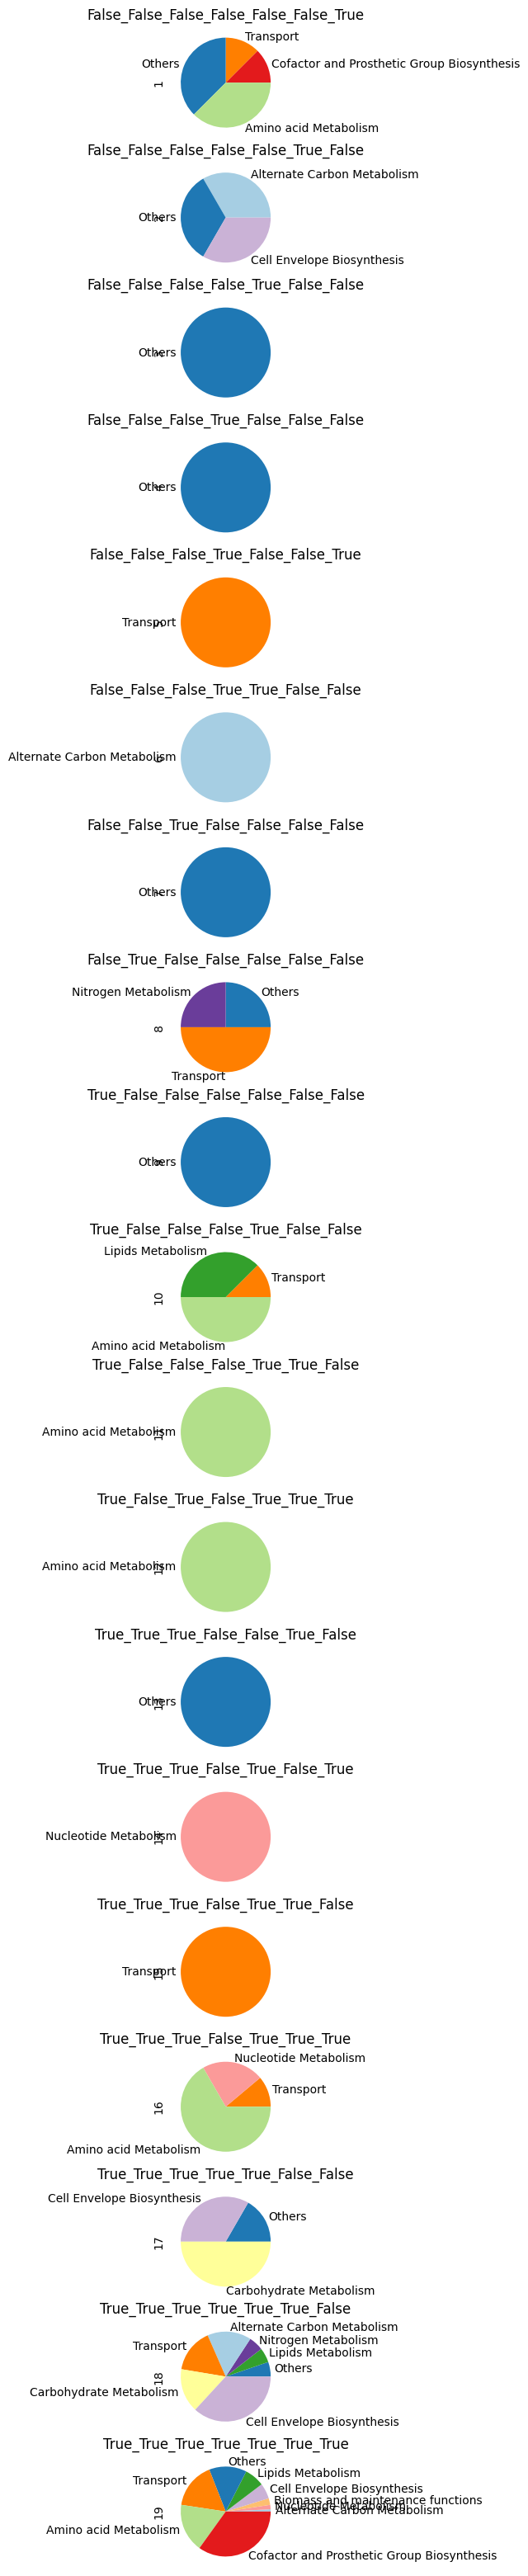

In [24]:
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
# color_dct = {k:c for k,c in zip(subsystems.index,colors)}
fig,ax = plt.subplots(len(dct),1,figsize=(5,40))
for idx,(g,lst) in enumerate(dct.items()):
    name = "_".join([str(i) for i in groups[g]])
    tmp = subsystems[g].fillna(0.).sort_values()
    tmp.plot.pie(colors=[color_dct[i] for i in tmp.index],ax=ax[idx])
    ax[idx].set_title(name)
    
plt.savefig("./figures/reaction-anaerobic-pies.svg",format="SVG")


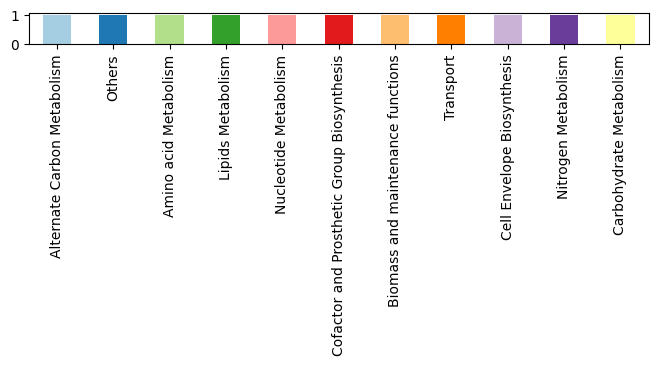

In [25]:
pandas.Series({k:1 for k in color_dct}).plot.bar(color=[color_dct[i] for i in color_dct],figsize=(8,0.4))
plt.savefig("./figures/reaction-anaerobic-colorbar.svg",format="SVG")